<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn as nn
import torch
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from datetime import datetime
from IPython.display import clear_output
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
STATS = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [4]:
# подгрузим данные с диска
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
# проверка, что файл есть
!ls  /content/gdrive/MyDrive/'DLS_GANs'/faces_dataset_small.zip

/content/gdrive/MyDrive/DLS_GANs/faces_dataset_small.zip


In [6]:
# распаковываем файл
!mkdir ./Flickr-Faces-Short data
!unzip -q /content/gdrive/MyDrive/DLS_GANs/faces_dataset_small.zip -d ./Flickr-Faces-Short/data

In [7]:
DATA_DIR = './Flickr-Faces-Short'

In [8]:
def get_dataloader(DATA_DIR, image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  dataset = ImageFolder(
      root = DATA_DIR,
          transform = transforms.Compose([
          transforms.Resize(image_size),
          transforms.CenterCrop(image_size),
          transforms.ToTensor(),
          transforms.Normalize(*STATS),
      ])
  )

  dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
  return dataloader, dataset

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
def print_images(images, nmax=64, stats=STATS, title='Original Images', denorm=True):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    plt.title(title)
    plt.axis("off")
    if denorm:
      ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    else:
      ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def print_batch(dl, nmax=64, stats=STATS):
    for images, _ in dl:
        print_images(images, nmax)
        break

def denormalize(img_tensors, stats=STATS):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
dataloader, dataset  = get_dataloader(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)

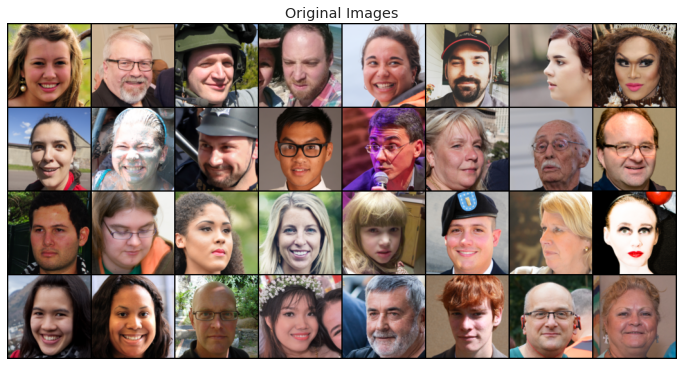

In [13]:
print_batch(dataloader)

In [14]:
# на девайс перенесем тут, чтобы не было проблем с выводом изображений
dataloader = DeviceDataLoader(dataloader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [15]:
LATENT_SIZE = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False), # точно сворачивает в два раза
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 64 x 64

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), # точно норм
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [18]:
FIXED_LATENT = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)

In [ ]:
PATH = './'
EXTENSION = '.pth'

def load_model(model_name):
    if (model_name != ''):
        model = torch.load(PATH + model_name + EXTENSION)
        model.to(device)


def save_model(model, epochs, model_name):
    torch.save({
        'discriminator': model["discriminator"],
        'generator': model["generator"],
        'discriminator_opt': optimizer["discriminator"],
        'generator_opt': optimizer["generator"],
        }, PATH + f'{model_name}_epochs-{epochs}_{datetime.now().isoformat(sep="_", timespec="seconds").replace(":", "-")}' + EXTENSION
    )

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalize(fake_images), os.path.join(PATH, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

def fit(model, optimizer, criterion, epochs, data_tr, model_name='GAN', load=False, start_idx=1):
    torch.cuda.empty_cache()
    gc.collect()

    # загрузка модели
    
    model["discriminator"].train()
    model["generator"].train()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):

        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        counter = 0
        for real_images, _ in tqdm(data_tr):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()
            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            # Generate fake images
            latent = torch.randn(real_images.size(0), LATENT_SIZE, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Pass fake images through discriminator
            fake_targets = fake_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.0, 0.05).to(device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(real_images.size(0), LATENT_SIZE, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

            counter += 1

        print('All trainings finished')
        # Record losses & scores
        epoch_g_loss = np.mean(loss_g_per_epoch)
        epoch_d_loss = np.mean(loss_d_per_epoch)
        epoch_real_score = np.mean(real_score_per_epoch)
        epoch_fake_score = np.mean(fake_score_per_epoch)

        losses_g.append(epoch_g_loss)
        losses_d.append(epoch_d_loss)
        real_scores.append(epoch_real_score)
        fake_scores.append(epoch_fake_score)

        # Visualize tools
        fake_images = denormalize(fake_images)
        real_images = denormalize(real_images)
        fig0 = plt.figure("Figure 0", figsize=(15,9))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.tight_layout()
            plt.imshow(fake_images[k].cpu().detach().permute(1, 2, 0))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.tight_layout()
            plt.imshow(real_images[k].cpu().detach().permute(1, 2, 0))
            plt.title('Output')
            plt.axis('off')

        first_suptitle = ("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                          epoch+1, epochs, epoch_g_loss, epoch_d_loss, epoch_real_score, epoch_fake_score)
        )
        plt.suptitle(f'{first_suptitle}')

        fig1 = plt.figure("Figure 1")
        plt.plot(losses_g, label="generator losses")
        plt.plot(losses_d, label="discriminator losses")

        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title('Losses')
        fig1.set_figheight(5)
        fig1.set_figwidth(15)
        
        plt.show()

        # save model each 50 epochs
        if (epoch % 50 == 0 and epoch > 0):
          save_model(model, MAX_EPOCHS, model_name)

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, FIXED_LATENT, show=False)

    # save_model(model, MAX_EPOCHS, model_name)

    return model, losses_g, losses_d, real_scores, fake_scores, fake_images

In [ ]:
# если уже модель существует, удалим ее, чтобы освободить память
if 'model' in globals():
    del model, optimizer, criterion
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
lr = 0.0005

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                      lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(),
                                  lr=lr, betas=(0.5, 0.999))
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

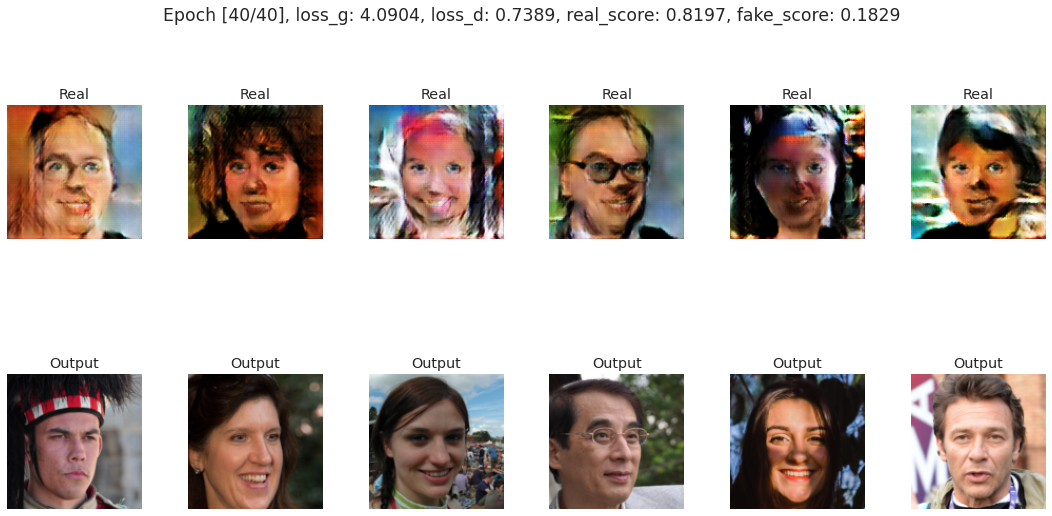

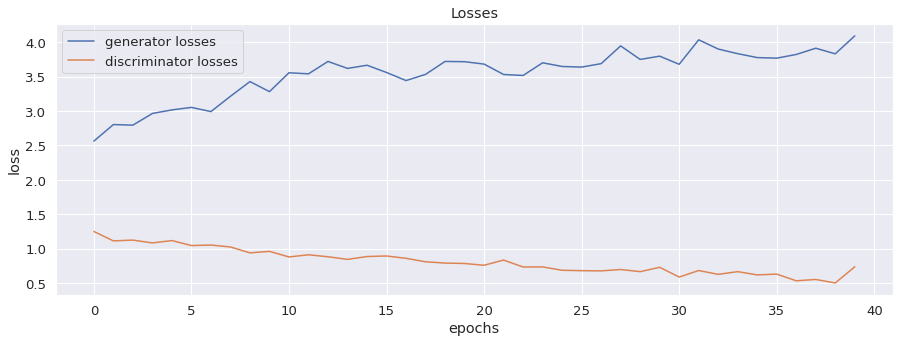

Saving generated-images-0040.png


In [ ]:
MAX_EPOCHS = 40
GAN, gen_losses, discr_losses, real_scores, fake_scores, fake_images = fit(model, optimizer, criterion, MAX_EPOCHS, dataloader)

In [40]:
def print_results(gen_losses, discr_losses, real_scores, fake_scores):
    # print losses
    fig0 = plt.figure("Figure 0", figsize=(15,6))
    plt.plot(gen_losses, label='Generator', linewidth=3)
    plt.plot(discr_losses, label='Discriminator', linewidth=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Generator', 'Discriminator'])
    plt.title('Losses');

    # print scores
    fig1 = plt.figure("Figure 1", figsize=(15,6))
    plt.plot(real_scores, 'g', label='Real', linewidth=3)
    plt.plot(fake_scores, 'r', label='Generated', linewidth=3)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend(['Real', 'Generated'])
    plt.title('Scores');

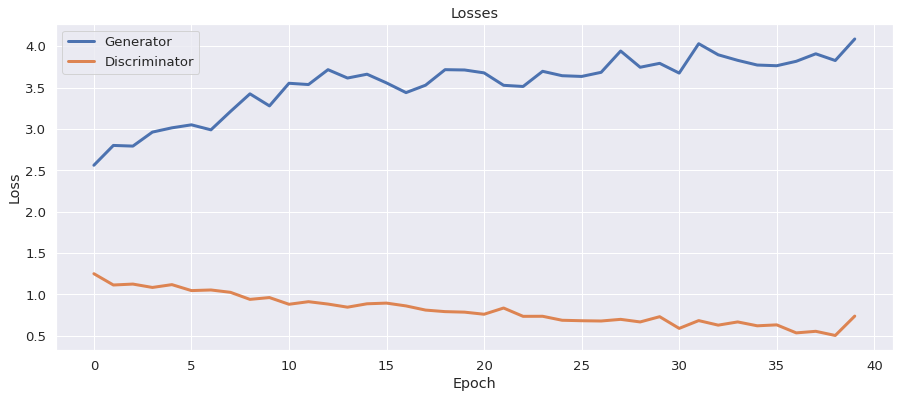

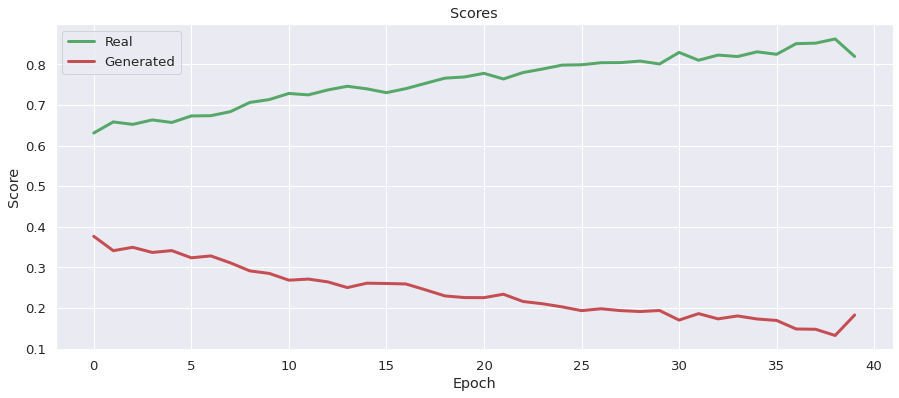

In [41]:
print_results(gen_losses, discr_losses, real_scores, fake_scores)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

*По графику лоссов видно, что у генератора тренд на повышение лосса, у дискриминатора - на понижение. Таким образом, видим, что генератор еще не научился генерировать такие изображения, чтобы дискриминатор не смог их отличить, из-за чего его лосс бы увеличивался.* \
*График скоров показвыает ту же картину, что дискриминатор уже научился хорошо отличать фейковые изображения, а генератор еще не научился его обманывать* \

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

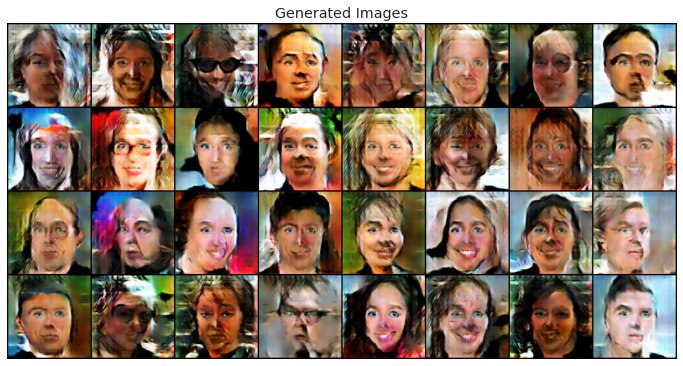

In [ ]:
# функция была написана ранее, поэтому просто выведем изображения
n_images = 32
fake_images = model["generator"](FIXED_LATENT)
print_images(fake_images.detach().cpu(), denorm=True, title='Generated Images')

Как вам качество получившихся изображений?

*Больше похоже не на фото, а на какой-то шарж(или на те искаженные мемы), но что-то общее с людскими лицами определенно есть*

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
def prepare_data(model, data_tr):
    model["discriminator"].train()
    model["generator"].train()

    real_images = torch.Tensor().to(device)
    fake_images = torch.Tensor().to(device)

    for batch_real_images, _ in tqdm(data_tr):
        with torch.no_grad():
            latent = torch.randn(batch_real_images.size(0), LATENT_SIZE, 1, 1, device=device)
            batch_fake_images = model["generator"](latent)
            real_images = torch.cat([real_images, batch_real_images], dim = 0)
            fake_images = torch.cat([fake_images, batch_fake_images], dim = 0)

    real_targets = torch.ones(real_images.size(0)).to(device)
    fake_targets = torch.zeros(real_images.size(0)).to(device)
    
    all_images = torch.cat([real_images, fake_images], dim = 0)
    all_targets = torch.cat([real_targets, fake_targets], dim = 0)

    all_images = all_images.detach().cpu().reshape(-1, 3 * 128 * 128)
    all_targets = all_targets.detach().cpu()

    return all_images, all_targets

In [ ]:
images, targets = prepare_data(model, dataloader)

  0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [ ]:
loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

In [ ]:
def get_loo_1nn_classifier_accuracy(images, targets, knn, leave_one_out):
  real = []
  predicted = []
  counter = 0
  for train_indexes, test_index in tqdm(leave_one_out.split(images, targets)):
      images_train, images_test = images[train_indexes], images[test_index]
      targets_train, targets_test = targets[train_indexes], targets[test_index]
      
      knn.fit(images_train, targets_train)
      pred = knn.predict(images_test)

      real.append(targets_test[0].item())
      predicted.append(pred[0])
      counter += 1
      
      if (counter % 250 == 0):
          torch.save(real, './scores/' + f'real_epochs-{counter}' + '.pth')
          torch.save(predicted, './scores/' + f'predicted_epochs-{counter}' + '.pth')
            

  return np.array(real), np.array(predicted) 
    

In [ ]:
real_targets, pred_targets = get_loo_1nn_classifier_accuracy(images, targets, knn, loo)
# всего 6286 эпох

0it [00:00, ?it/s]

In [ ]:
torch.save(real_targets, './scores/' + f'real_epochs-{6286}' + '.pth')
torch.save(pred_targets, './scores/' + f'predicted_epochs-{6286}' + '.pth')

In [ ]:
accuracy_history = accuracy_score(real_targets, pred_targets)

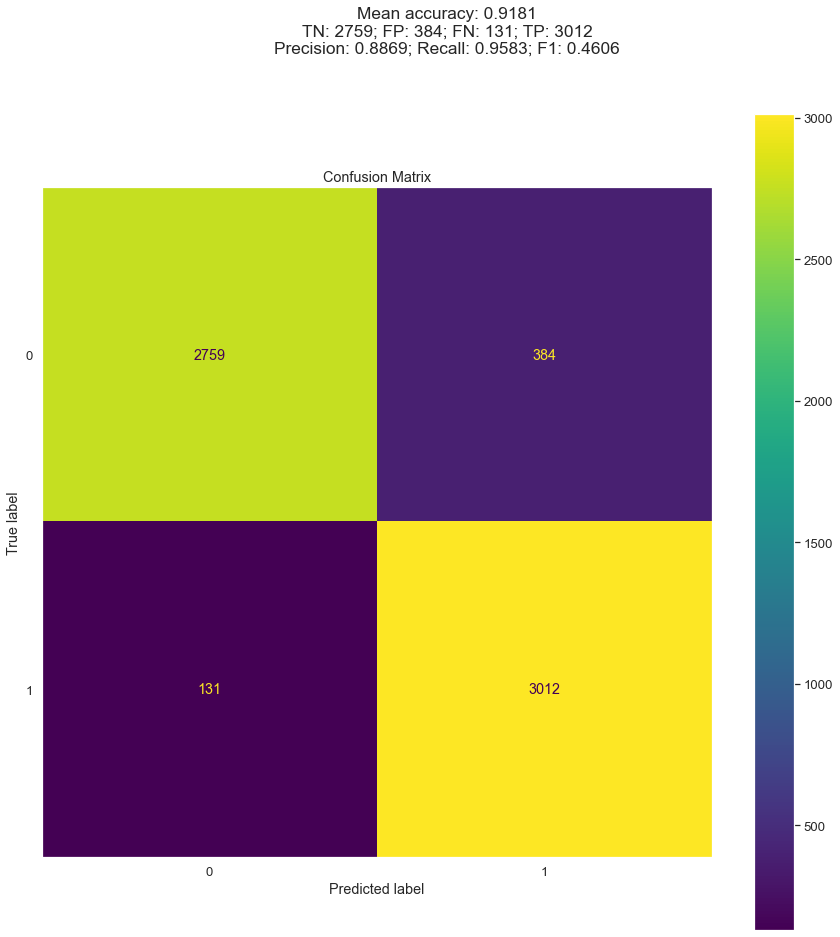

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 

matrix =  confusion_matrix([rt for rt in real_targets], [pt for pt in pred_targets])
TN = matrix[0][0]
FP  = matrix[0][1]
FN = matrix[1][0]
TP = matrix[1][1]
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
F1 = Precision*Recall / (Precision + Recall)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion Matrix')
first_subtitle = ("Mean accuracy: {:.4f}\n".format(np.mean(accuracy_history)))
second_subtitle = ("TN: {}; FP: {}; FN: {}; TP: {}\n".format(TN, FP, FN, TP))
third_subtitle = ("Precision: {:.4f}; Recall: {:.4f}; F1: {:.4f}\n".format(Precision, Recall, F1))
plt.suptitle(f'{first_subtitle + second_subtitle + third_subtitle}')
plt.show()

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

*Получившийся результат неудовлетворительный, так как accuracy составляет ~0.92, что говорит о том, что дискриминатор довольно хорошо различает сгенерированные изображения и реальные, и поэтому редко ошибается, а это значит, что качество генерируемых изображений оставляет желать лучшего* \
*Как вариант, чтобы исправить ситуация стоило взять больше эпох или использовать буффер*

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
images = images.detach().cpu().reshape(-1, 3 * 128 * 128)
targets = targets.detach().cpu()

In [ ]:
tsne_date = TSNE(n_components=2, learning_rate='auto',
                  init='random', random_state=42).fit_transform(images)
tsne_date = torch.Tensor(tsne_date)

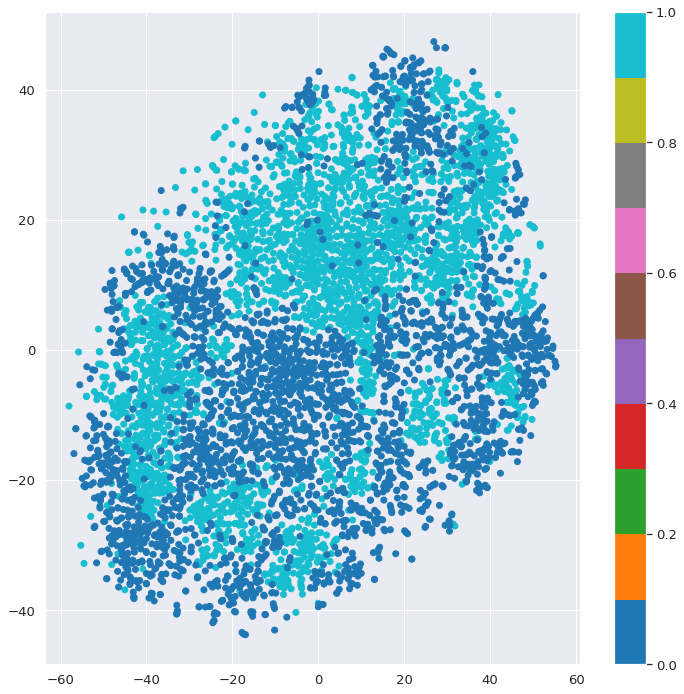

In [ ]:
plt.subplots(figsize=(12, 12))
plt.scatter(tsne_date[:, 0], tsne_date[:, 1], c=targets, cmap='tab10')
plt.colorbar()

Прокомментируйте получившийся результат:

*В целом, распределение показывает, что два класса линейно разделимы, так как мы можем отделить большие скопления сгенерированных объектов от реальных(понятно, что какие-то объекты будут не соответствовать своей группе), что подтверждает гипотезу, выведенную с графиков лоссов и матрицы ошибок, о том, что генератор недостаточно обучился и дискриминатор с небольшим процентов ошибок может отделить сгенерированный изображения от реальных*